## Analyze A/B Test Results

This project is a A/B Test run on an e-commerce website to decide wether they should implement the new web page, keep the old page, or perhaps runt the experiment longer to make their decision.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. The results of an A/B test run by an e-commerce website should help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

Import libraries.

In [182]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Setting the seed to assure same answers on quizzes
random.seed(42)

Read in the dataset and take a look at the top few rows:

In [183]:
# Read in dataset from csv and store in df
df = pd.read_csv('ab_data.csv')

# Check top rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset:

In [184]:
# Number of rows in dataset
df.shape[0]

294478

The number of unique users in the dataset:

In [185]:
# Number of unique users in dataset
len(df['user_id'].unique())

290584

The proportion of users converted:

In [186]:
# proportion of converted values in complete dataframe
total_CR = df.query('converted == 1').user_id.nunique()/df.user_id.nunique()
total_CR

0.12104245244060237

In [187]:
# Divide df into dataframes for groups
control_df = df.query('group == "control"')
treatment_df = df.query('group == "treatment"')

In [188]:
# Proportion of converted values in control group of dataframe
control_CR = control_df.query('converted == 1').user_id.nunique()/treatment_df.user_id.nunique()
control_CR

0.12102485576002844

In [189]:
# Proportion of converted values in treatment group of dataframe
treatment_CR = treatment_df.query('converted == 1').user_id.nunique()/treatment_df.user_id.nunique()
treatment_CR

0.11957562002679718

The number of times the `new_page` and `treatment` don't match:

In [190]:
#checking amount of rows with non-exlpicable combinations of group and landing_page
len(df.query('group == "treatment" and landing_page == "old_page" or group == "control" and landing_page == "new_page"'))

3893

Check if any of the rows have missing values:

In [191]:
# Check if all columns have same amount of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

In [192]:
# Create dataframe2 with rows of dataframe, where treatment group matches new_page and control group matches old_page
df2 = df.query('group == "treatment" and landing_page == "new_page" or group == "control" and landing_page == "old_page"')

In [193]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [194]:
# Check for amount of unique user_ids 
df2.user_id.nunique()

290584

In [195]:
# Check amount of rows
df2.shape[0]

290585

There is one **user_id** repeated in **df2**.

In [196]:
# Check for how of often user_ids appear in dataframe2
df2.user_id.value_counts().head()

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

Row information for the repeat **user_id**:

In [197]:
# Check values of rows for user_id 773192 
df2.query('user_id == "773192"')


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**:

In [198]:
# Drop row with index 2893
df2 = df2.drop(2893)


In [199]:
# Check if just one row for user_id 773192 left
df2.query('user_id == "773192"')


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


Probability of an individual converting regardless of the page they receive:

In [200]:
# Proportion of converted user_ids in dataframe2
CR = df2.converted.mean()
CR

0.11959708724499628

Probability an individual converted, given that individual was in the `control` group:

In [201]:
# Proportion of converted user_ids of control group in dataframe2
control_df2 = df2.query('group == "control"')
obs_p_old = control_df2.converted.mean()
obs_p_old

0.1203863045004612

Probability an individual converted, given that individual was in the `treatment` group.

In [202]:
# Proportion of converted user_ids of treatment group in dataframe2
treatment_df2 = df2.query('group == "treatment"')
obs_p_new = treatment_df2.converted.mean()
obs_p_new

0.11880806551510564

Probability that an individual received the new page:

In [203]:
# Proportion of new_page in dataframe2
len(df2.query('landing_page == "new_page"'))/len(df2)


0.5000619442226688

In [204]:
# Calculation observed difference in conversion rate of new page/treatment grpup versus old page/control group
real_obs_diff = obs_p_new - obs_p_old
real_obs_diff

-0.0015782389853555567

Given that the probability of converting is 12,04%, when beeing in the control group and 11,96%, when beeing in the treatment group, there is not sufficient evidence to conclude that the new treatment page leads to more conversion. The conversion rate in the control group with the old page is unsignificantly higher than in the the treatment page with the new page.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, it is technically possible to run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long mus the test run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, we make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, our hypothesis are the following:

$H_0: p_{new} \leq p_{old}$: Old page has equal or higher conversion rate than new page.

$H_1: p_{new} > p_{old}$: Old page has lower conversion rate than new page.

Alternative description:

$H_0: p_{new} - p_{old} \leq 0$

$H_1: p_{new} - p_{old} > 0 $


$\alpha = 5\%$

If $p-value \leq \alpha \Rightarrow$ Reject $H_0$

else $\Rightarrow$ Fail to reject $H_0$

We assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Assumption at $H_0: p_{new} = p_{old} =CR$

We use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

We perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


**Conversion rate** for $p_{new}$ under the null:

In [205]:
# Assume p_new is equal to conversion rate of df2
p_new = CR 
p_new

0.11959708724499628

**Conversion rate** for $p_{old}$ under the null:

In [206]:
# Assume p_old is equal to conversion rate of d2
p_old = CR 
p_old

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group:

In [207]:
# Length of n_new
n_new = treatment_df2.shape[0]
n_new


145310

$n_{old}$, the number of individuals in the control group:

In [208]:
# Length of n_old
n_old = control_df2.shape[0]
n_old


145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null:

In [209]:
# Pick randomly n_new rows of the df2 with converison rate p_new while replacing
new_page_converted = df2.sample(n_new, replace=True)

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null:

In [210]:
# Pick randomly n_old rows of the df2 with converison rate p_new while replacing
old_page_converted = df2.sample(n_old, replace=True)

$p_{new}$ - $p_{old}$ for simulated values:

In [211]:
# Calculate the p_new - p_old for simulated values
simulated_obs_diff = new_page_converted.converted.mean() - old_page_converted.converted.mean()
simulated_obs_diff

-0.00059378813717857193

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process:

In [212]:
# Bootsampling of df2 with samplesize=length of df2 and 10000
p_diffs=[]

for i in range(10000):
    old_page_converted = df2.sample(n_old, replace=True)
    new_page_converted = df2.sample(n_new, replace=True)
    p_diffs.append(new_page_converted.converted.mean() - old_page_converted.converted.mean())

# Converte diffs to numpy array
p_diffs = np.array(p_diffs)

Plot a histogram of the **p_diffs**:

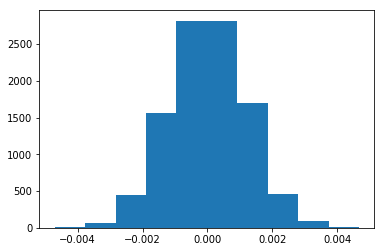

In [213]:
# Plot histogramm of sampling distribution
plt.hist(p_diffs);
# Normal distribution for H_0, saying p_new has the same conversion rate as p_old

Proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**:

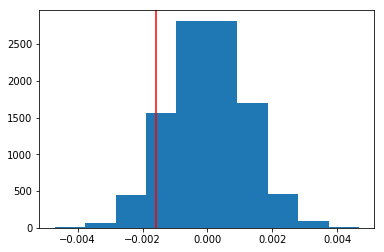

In [214]:
# Plot histogramm of sampling distribution including observed value
plt.hist(p_diffs);
plt.axvline(x=real_obs_diff, color='red');


In [215]:
# Calculate p-value, the probability of observing the difference in p_new to p_old as in real_obs_diff, when assuming H0 is true
p_value = (p_diffs > real_obs_diff).mean()
# As we stated, that p_new-p_old <= 0 for H0, we calculate the proportion of values that are part of the H0 sample distribution and bigger than the observed value real_obs_diff
p_value

0.90739999999999998

In [216]:
real_obs_diff

-0.0015782389853555567

**Conclusion:**
If $H_0$ is true and therfore the conversion rate of the old page $p_{old}$ ist equal or higher than the conversion rate of the new page $p_{new}$, the p-value expresses the probability of obtaining the observed statistic in difference (real_obs_diff), or one more extreme in favor for the alternative Hypothesis. In the case of the data in df2 the p-value for $H_0$ and real_obs_diff is 90.56% . Thus, we fail to reject the null hypothesis $H_0$.

We could also use a built-in to achieve similar results. `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively:

In [217]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [218]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = len(df2.query('landing_page == "old_page" and converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" and converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

Now with `stats.proportions_ztest` to compute your test statistic and p-value.  [Link](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) 

In [219]:
#count
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
value = 0
stat, pval = proportions_ztest(count, nobs, alternative='larger')
stat, pval 


(-1.3109241984234394, 0.90505831275902449)

**Conclusion:**
"The z-score measures the distance of the observed value to the mean in a standard deviation unit and is calculated by:
$z = (x-\mu ) / \sigma $" [[Udacity-Blog](#https://knowledge.udacity.com/questions/83070)]

In the case of df2 the z-score is -1.31, meaning the observed value is 1.3 times the standard devitation on the left of the center value.

"Z-score below 1.5 means that the convertion rate for the new page is less than he 95% of the old page re-enforcing that we cannot reject the null hypotesis." [[Udacity-Blog](#https://knowledge.udacity.com/questions/83070)]

Using the proportions_ztest function the resulting p-value ist 90.5%, which is very close to the p-value of 90,7% calculated with the bootsampling above. The built-in function assures the former conclusion that the H0 Hypothesis can not be rejected based on the data in df2.

<a id='regression'></a>
### Part III - A regression approach

Result achieved in the A/B test in Part II above can also be achieved by performing regression.

Since each row is either a conversion or no conversion, we have two possible outcomes or two-tailed problems. as here with conversion versus no conversion, it is favourable to use logistic regression based on a sigmoids.

Goal is to use **statsmodels** to fit the regression model specified to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.

In [220]:
# Create a intercept column with values 1, as we expect the value of the response variable to be 1, when the eplanatory variables are 0
df2['intercept']=1

# Create dummy variables for categorical value old_page/new_page
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

# Drop baseline category old page
df2 = df2.drop(['old_page'], axis=1)

In [221]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Use **statsmodels** to instantiate regression model, then fit the model to predict whether or not an individual converts. 

In [222]:
# Initiate a logistic regression model using Logit with response variable "converted" and explanatory variable "ab_page"
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

# Fit the model to predict wether or not an individual converts
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of model

In [223]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-29 17:05 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

P-value associated with **ab_page**:


The p>|z| value of ab_page is 0.1899, beeing >0.05. Thus, the variable ab_page is not considered to be statistically significant.

The $H_0$ hypothesis of this regression model is $p_{new} = p_{old}$ and the $H_1$ hypothesis is that $p_{new} \neq p_{old}$. This can be read that the p-value is formulated as p>|z|, meaning the probability of obtaining such value (positive or negative) or more extreme in favor of the alternative hypothesis. It considers all values smaller than z and bigger than -z. 

The Hypothesis we formulated for the bootstrapping sample in **Part II** was $H_0: p_{new} - p_{old} \leq 0$ and $H_1: p_{new} - p_{old} > 0 $, meaning our p-values describes all values bigger than z.

The z-value for ab_page is the exact same as when using proportions_ztest. Converting the p>|z| value to the p-value for our Hypothesis can be done by $ 1 - (p>|z| / 2) $, as we are interested in the proportion of values that are >z. Thus, the p-value in this logistiv regression model is 90.0505%


It would be a good idea to add other factors to the regression model to gain statistical significance as p>|z| beeing <0.05
Disadvantage of adding addtional terms in regression model is the risk that predictor variables are correlated with one another.

Test if the conversion rate changes for different pages, adding an effect based on which country a user lives in. 
Does it appear that country had an impact on conversion?

In [224]:
# Read csv
dfc = pd.read_csv('countries.csv')
dfc.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [225]:
# Join the country column to existing df2
df2 = df2.set_index('user_id').join(dfc.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [226]:
# Check for possible values in country-column
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [227]:
# Create dummy variables for categorical value country
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

# Drop baseline category US
df2 = df2.drop(['US'], axis=1)

df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


In [228]:
# Initiate a logistic regression model using Logit with response variable "converted" and explanatory variables "ab_page", "UK" and "CA"
logit_mod = sm.Logit(df2['converted'], df2[['intercept','CA','UK']])

# Fit the model to predict wether or not an individual converts
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


Summary of model

In [229]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-29 17:05 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [230]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

The coefficients of the result table indicate, that when a user accesses the page from CA he is 4.1% less probable to convert than when crom US, and when from UK 1% more probable than from US.
None of the explanatory variables seem to be statistically significant, as all p-values are >0.05. 
The differences in the response variable conversion rate caused by the explanatory variable country seem to be neither statistically significant nor practical signicicant.
Therefore is is advisable not to reject the $H_0$.

Check interaction between page and country to see if there significant effects on conversion.

In [231]:
# Initiate a logistic regression model using Logit with response variable "converted" and explanatory variables "ab_page", "UK" and "CA"
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page','CA','UK']])

# Fit the model to predict wether or not an individual converts
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


Summary of model

In [232]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-29 17:05 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [233]:
1/np.exp(-0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

The coefficients of the result table indicate, that when landing on the new page compared to landing on the old page, the the probability of the user converting is 1.5% less. When a user accesses the page from CA he is 4.1% less probable to convert than when crom US, and when from UK 1% more probable than from US.
None of the explanatory variables seem to be statistically significant, as all p-values are >0.05. 
The differences in the response variable conversion rate caused by the explanatory variables page or country seem to be neither statistically significant nor practical signicicant.
Therefore is is advisable not to reject the $H_0$.

In [234]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0